In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.6335

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - loss: 0.5332
Average validation loss: 0.6623400449752808
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - loss: 0.5332 - val_loss: 0.6623
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - loss: 0.4111 - val_loss: 0.6623
Average validation loss: 0.24239560961723328
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 520ms/step - loss: 0.4111 - val_loss: 0.4524
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - loss: 0.3343 - val_loss: 0.4524
Average validation loss: 0.37897491455078125
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 524ms/step - loss: 0.3343 - val_loss: 0.4279
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 507ms/step - loss: 0.2785 - val_loss: 0.4279
Average validation loss: 0.20

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 936ms/step - loss: 0.0458
Average validation loss: 0.1638270542025566
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 951ms/step - loss: 0.0458 - val_loss: 0.1638
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 872ms/step - loss: 0.0473 - val_loss: 0.1638
Average validation loss: 0.19968381524085999
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 881ms/step - loss: 0.0473 - val_loss: 0.1818
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 914ms/step - loss: 0.0436 - val_loss: 0.1818
Average validation loss: 0.108858123421669
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 930ms/step - loss: 0.0436 - val_loss: 0.1575
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_10.pth'.
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 819ms/step - loss: 0.0415 - val_loss: 0.1575
Average validation loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 858ms/step - loss: 0.0318
Average validation loss: 0.03904624159137408
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 872ms/step - loss: 0.0318 - val_loss: 0.0390
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 930ms/step - loss: 0.0255 - val_loss: 0.0390
Average validation loss: 0.14204455042878786
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 942ms/step - loss: 0.0255 - val_loss: 0.0905
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 970ms/step - loss: 0.0224 - val_loss: 0.0905
Average validation loss: 0.07480276748538017
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 982ms/step - loss: 0.0224 - val_loss: 0.0853
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 835ms/step - loss: 0.0208 - val_loss: 0.0853
Average validation loss: 0.0421977782001098
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 850ms/step - loss: 0.0208 - val_loss: 0.0745
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 53s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 815ms/step - loss: 0.0147
Average validation loss: 0.010380830033682287
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 825ms/step - loss: 0.0147 - val_loss: 0.0104
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 845ms/step - loss: 0.0103 - val_loss: 0.0104
Average validation loss: 0.025037580751813948
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 857ms/step - loss: 0.0103 - val_loss: 0.0177
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 792ms/step - loss: 0.0085 - val_loss: 0.0177
Average validation loss: 0.011485541297588497
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 805ms/step - loss: 0.0085 - val_loss: 0.0156
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 839ms/step - loss: 0.0076 - val_loss: 0.0156
Average validation loss: 0.006835854146629572
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 851ms/step - loss: 0.0076 - val_loss: 0.0134
Saved model weights to 'c:\天_11157065

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 814ms/step - loss: 0.0135
Average validation loss: 0.009807890467345714
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 826ms/step - loss: 0.0135 - val_loss: 0.0098
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 841ms/step - loss: 0.0106 - val_loss: 0.0098
Average validation loss: 0.012053559627383947
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 854ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 793ms/step - loss: 0.0088 - val_loss: 0.0109
Average validation loss: 0.007820641761645675
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 806ms/step - loss: 0.0088 - val_loss: 0.0099
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 796ms/step - loss: 0.0076 - val_loss: 0.0099
Av

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 794ms/step - loss: 0.0168
Average validation loss: 0.0057123063985879225
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 806ms/step - loss: 0.0168 - val_loss: 0.0057
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 824ms/step - loss: 0.0123 - val_loss: 0.0057
Average validation loss: 0.0032763422447411963
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 836ms/step - loss: 0.0123 - val_loss: 0.0045
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 794ms/step - loss: 0.0102 - val_loss: 0.0045
Average validation loss: 0.0055942807424192624
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 806ms/step - loss: 0.0102 - val_loss: 0.0049
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 809ms/step - loss: 0.0090 - val_loss: 0.0049

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 922ms/step - loss: 0.0141
Average validation loss: 0.010147621692158281
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 933ms/step - loss: 0.0141 - val_loss: 0.0101
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 796ms/step - loss: 0.0100 - val_loss: 0.0101
Average validation loss: 0.008313798904418945
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 807ms/step - loss: 0.0100 - val_loss: 0.0092
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 101s 782ms/step - loss: 0.0085 - val_loss: 0.0092
Average validation loss: 0.011543477268423885
40/40 ━━━━━━━━━━━━━━━━━━━━ 101s 793ms/step - loss: 0.0085 - val_loss: 0.0100
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 788ms/step - loss: 0.0075 - val_loss: 0.0100

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 795ms/step - loss: 0.0075
Average validation loss: 0.005689129444363061
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 809ms/step - loss: 0.0075 - val_loss: 0.0057
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 816ms/step - loss: 0.0058 - val_loss: 0.0057
Average validation loss: 0.003981752934729836
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 829ms/step - loss: 0.0058 - val_loss: 0.0048
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 861ms/step - loss: 0.0048 - val_loss: 0.0048
Average validation loss: 0.0038085792475612834
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 875ms/step - loss: 0.0048 - val_loss: 0.0045
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_se

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 908ms/step - loss: 0.0063
Average validation loss: 0.006326254947842764
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 921ms/step - loss: 0.0063 - val_loss: 0.0063
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 797ms/step - loss: 0.0054 - val_loss: 0.0063
Average validation loss: 0.006854039450575199
56/56 ━━━━━━━━━━━━━━━━━━━━ 97s 810ms/step - loss: 0.0054 - val_loss: 0.0066
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 803ms/step - loss: 0.0045 - val_loss: 0.0066
Average validation loss: 0.0043365227757021785
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 816ms/step - loss: 0.0045 - val_loss: 0.0058
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 187s 795ms/step - loss: 0.0041 - val_loss: 0.005

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 908ms/step - loss: 0.0047
Average validation loss: 0.007835111387976212
64/64 ━━━━━━━━━━━━━━━━━━━━ 59s 921ms/step - loss: 0.0047 - val_loss: 0.0078
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 111s 814ms/step - loss: 0.0039 - val_loss: 0.0078
Average validation loss: 0.007111934821296018
64/64 ━━━━━━━━━━━━━━━━━━━━ 112s 827ms/step - loss: 0.0039 - val_loss: 0.0075
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 164s 822ms/step - loss: 0.0034 - val_loss: 0.0075
Average validation loss: 0.006687297020107508
64/64 ━━━━━━━━━━━━━━━━━━━━ 165s 835ms/step - loss: 0.0034 - val_loss: 0.0072
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_s

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 804ms/step - loss: 0.0035
Average validation loss: 0.007696777252325167
72/72 ━━━━━━━━━━━━━━━━━━━━ 59s 818ms/step - loss: 0.0035 - val_loss: 0.0077
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 124s 903ms/step - loss: 0.0030 - val_loss: 0.0077
Average validation loss: 0.011287269824404374
72/72 ━━━━━━━━━━━━━━━━━━━━ 125s 916ms/step - loss: 0.0030 - val_loss: 0.0095
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 190s 912ms/step - loss: 0.0026 - val_loss: 0.0095
Average validation loss: 0.007608684714392034
72/72 ━━━━━━━━━━━━━━━━━━━━ 191s 925ms/step - loss: 0.0026 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 251s 827ms/step - loss: 0.0025 - val_loss: 0.00

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 824ms/step - loss: 0.0044
Average validation loss: 0.009135295725718607
80/80 ━━━━━━━━━━━━━━━━━━━━ 67s 838ms/step - loss: 0.0044 - val_loss: 0.0091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 809ms/step - loss: 0.0036 - val_loss: 0.0091
Average validation loss: 0.002828766500169877
80/80 ━━━━━━━━━━━━━━━━━━━━ 133s 822ms/step - loss: 0.0036 - val_loss: 0.0060
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 197s 801ms/step - loss: 0.0031 - val_loss: 0.0060
Average validation loss: 0.005791250766196754
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 814ms/step - loss: 0.0031 - val_loss: 0.0059
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 264s 823ms/step - loss: 0.0029 - val_loss: 0.

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 820ms/step - loss: 0.0042
Average validation loss: 0.009003798326981874
96/96 ━━━━━━━━━━━━━━━━━━━━ 80s 834ms/step - loss: 0.0042 - val_loss: 0.0090
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 157s 797ms/step - loss: 0.0036 - val_loss: 0.0090
Average validation loss: 0.010644811125530396
96/96 ━━━━━━━━━━━━━━━━━━━━ 158s 810ms/step - loss: 0.0036 - val_loss: 0.0098
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 235s 805ms/step - loss: 0.0032 - val_loss: 0.0098
Average validation loss: 0.009401490109060736
96/96 ━━━━━━━━━━━━━━━━━━━━ 236s 818ms/step - loss: 0.0032 - val_loss: 0.0097
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 313s 796ms/step - loss: 0.0029 - val_loss: 0.0097
Average validation loss: 0.01000631986244116
96/96 ━━━━━━━━━━━━━━━━━━━━ 314s 809ms/step - loss: 0.0029 - val_loss: 0.0098
Epoch 5/10
96/96 ━━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 800ms/step - loss: 0.0072
Average validation loss: 0.005323228969549139
120/120 ━━━━━━━━━━━━━━━━━━━━ 98s 813ms/step - loss: 0.0072 - val_loss: 0.0053
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 798ms/step - loss: 0.0055 - val_loss: 0.0053
Average validation loss: 0.00708410673638961
120/120 ━━━━━━━━━━━━━━━━━━━━ 195s 811ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 311s 969ms/step - loss: 0.0049 - val_loss: 0.0062
Average validation loss: 0.006466055548905085
120/120 ━━━━━━━━━━━━━━━━━━━━ 313s 983ms/step - loss: 0.0049 - val_loss: 0.0063
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 409s 801ms/step - loss: 0.0044 - val_loss: 0.0063
Average validation loss: 0.005854875317891128
120/120 ━━━━━━━━━━━━━━━━━━━━ 410s 814ms/step - loss: 0.0044 - val_loss: 0.0062
Epoch 5/10
120/

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 795ms/step - loss: 0.0071
Average validation loss: 0.014166294744225323
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 808ms/step - loss: 0.0071 - val_loss: 0.0142
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 795ms/step - loss: 0.0056 - val_loss: 0.0142
Average validation loss: 0.007898911837805321
144/144 ━━━━━━━━━━━━━━━━━━━━ 233s 807ms/step - loss: 0.0056 - val_loss: 0.0110
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 347s 794ms/step - loss: 0.0049 - val_loss: 0.0110
Average validation loss: 0.00684984226649653
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 807ms/step - loss: 0.0049 - val_loss: 0.0096
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weigh

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 128s 803ms/step - loss: 0.0043
Average validation loss: 0.006662546696315985
160/160 ━━━━━━━━━━━━━━━━━━━━ 130s 815ms/step - loss: 0.0043 - val_loss: 0.0067
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 259s 801ms/step - loss: 0.0034 - val_loss: 0.0067
Average validation loss: 0.004934926781425019
160/160 ━━━━━━━━━━━━━━━━━━━━ 261s 814ms/step - loss: 0.0034 - val_loss: 0.0058
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 388s 796ms/step - loss: 0.0030 - val_loss: 0.0058
Average validation loss: 0.006639812477806118
160/160 ━━━━━━━━━━━━━━━━━━━━ 390s 809ms/step - loss: 0.0030 - val_loss: 0.0061
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 517s 795ms/step - loss: 0.002

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 807ms/step - loss: 0.0041
Average validation loss: 0.023352130925943584
200/200 ━━━━━━━━━━━━━━━━━━━━ 164s 820ms/step - loss: 0.0041 - val_loss: 0.0234
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 326s 812ms/step - loss: 0.0035 - val_loss: 0.0234
Average validation loss: 0.003968263065980864
200/200 ━━━━━━━━━━━━━━━━━━━━ 329s 825ms/step - loss: 0.0035 - val_loss: 0.0137
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 511s 912ms/step - loss: 0.0031 - val_loss: 0.0137
Average validation loss: 0.004914456503865949
200/200 ━━━━━━━━━━━━━━━━━━━━ 514s 924ms/step - loss: 0.0031 - val_loss: 0.0107
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 680s 833ms/step - loss: 0.002

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 791ms/step - loss: 0.0036
Average validation loss: 0.007416884411468535
240/240 ━━━━━━━━━━━━━━━━━━━━ 193s 804ms/step - loss: 0.0036 - val_loss: 0.0074
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 383s 791ms/step - loss: 0.0029 - val_loss: 0.0074
Average validation loss: 0.004800130857041237
240/240 ━━━━━━━━━━━━━━━━━━━━ 386s 804ms/step - loss: 0.0029 - val_loss: 0.0061
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 576s 792ms/step - loss: 0.0026 - val_loss: 0.0061
Average validation loss: 0.013120208369331603
240/240 ━━━━━━━━━━━━━━━━━━━━ 579s 805ms/step - loss: 0.0026 - val_loss: 0.0084
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 770s 794ms/step - loss: 0.002

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.19495187669992448, 0.11076710985973477, 0.03373618861970802, 0.013206287123030052, 0.01111678658548044, 0.011952562261431012, 0.007367570086702471, 0.004710683124236917, 0.00457936261283716, 0.004078695091993723, 0.006018648194828227, 0.0031297659145348013, 0.004861136522037365, 0.011323401403846219, 0.006548869535822715, 0.006217412128891987, 0.006915017673483904, 0.006882015456945194]
std_val_losses =  [0.15913828486573137, 0.15811288637556997, 0.035327416228413865, 0.02749512104149991, 0.009093159899736768, 0.024833133839824207, 0.005126653419892664, 0.0028546902135840905, 0.0025851158050108213, 0.0026705040934007383, 0.01057104204195879, 0.00232473488843719, 0.004370881887847011, 0.016289165602041192, 0.004166585334206285, 0.008105377880437834, 0.009748029455489582, 0.00906145228478319]


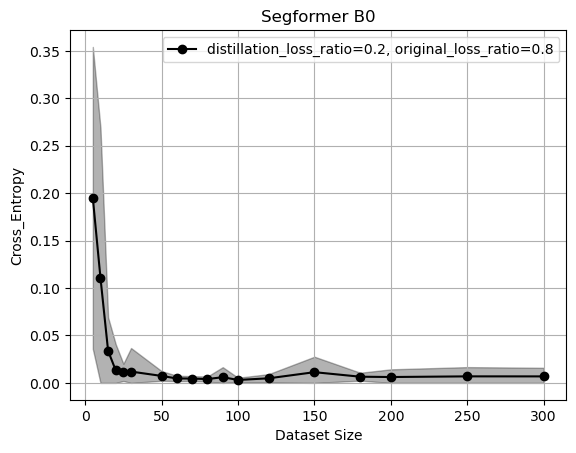

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()